# Query SnowEx database for the data we want
* Seth Vanderwilt
* coldfusion GPR-LiDAR
* 7/12/22

## Imports (from https://snowex.hackweek.io/tutorials/core-datasets/03_database_preview.html)

In [1]:
# standard imports
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt 
import datetime

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas

In [14]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


## Queries to see which kinds of data we have available

In [ ]:
# from https://snowex.hackweek.io/tutorials/database/2_database_structure.html

# Import the function to investigate a table
from snowexsql.db import get_table_attributes

# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))


These are the available columns in the table:
 
* date
* date_accessed
* doi
* easting
* elevation
* equipment
* geom
* instrument
* latitude
* longitude
* metadata
* northing
* observers
* registry
* site_id
* site_name
* time
* time_created
* time_updated
* type
* units
* utm_zone
* value
* version_number



In [41]:
# session.query(PointData.site_id).distinct().all() # None
# session.query(PointData.registry).distinct().all() # registry fails for some reason?
session.query(PointData.doi).distinct().all()

[('https://doi.org/10.5067/WE9GI1GVMQF6',),
 (None,),
 ('https://doi.org/10.5067/Q2LFK0QSVGS2',),
 ('https://doi.org/10.5067/S5EGFLCIAB18',),
 ('https://doi.org/10.5067/9IA978JIACAR',)]

In [42]:
query = session.query(PointData.type)
query = query.filter(PointData.doi == "https://doi.org/10.5067/Q2LFK0QSVGS2")
types = query.distinct().all()
types

[('depth',), ('swe',), ('two_way_travel',)]

In [20]:
point_site_names = session.query(PointData.site_name).distinct().all()
point_site_names # [(None,), ('Grand Mesa',)]

[(None,), ('Grand Mesa',)]

In [19]:
point_observers = session.query(PointData.observers).distinct().all() # Tate Meehan
point_observers

[('Catherine Breen, Cassie Lumbrazo',),
 (None,),
 ('Ryan Webb',),
 ('Randall Bonnell',),
 ('Tate Meehan',)]

### GPR is point data, so let's query the database to see which point data corresponds to Grand Mesa GPR

In [15]:
# Grab all Point data instruments from our date
point_instruments = session.query(PointData.instrument).distinct().all()
point_type = session.query(PointData.type).distinct().all()


# Clean up point data (i.e. remove tuple)
point_instruments_list = [p[0] for p in point_instruments if p[0] is not None]
point_instruments = ", ".join(point_instruments_list)
point_type_list = [p[0] for p in point_type]
point_type = ", ".join(point_type_list)
print('Point data are: %s, with the following list of parameters: %s' %(point_instruments, point_type))


Point data are: Mala 1600 MHz GPR, Mala 800 MHz GPR, pulse EKKO Pro multi-polarization 1 GHz GPR, pit ruler, mesa, magnaprobe, camera, with the following list of parameters: swe, depth, two_way_travel


Looking at https://nsidc.org/data/snowex/data_summaries we see that in 2020 there are some GPR datasets:
* BSU Grand Mesa **what we want to start, appears to be "pulse EKKO Pro multi-polarization 1 GHz GPR"**
    - https://nsidc.org/data/SNEX20_BSU_GPR/versions/1
* CSU Cameron Pass
* NMU Jemez

In [23]:
bsu_gpr_instrument_name = "pulse EKKO Pro multi-polarization 1 GHz GPR"

In [29]:
query = session.query(PointData.observers)
# fixed bug: have to do `query = query.filter(...)` to modify the query
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

bsu_gpr_observer = query.distinct().all()
bsu_gpr_observer

# From this, we see that Tate was not the only one out there collecting GPR data with the BSU GPR
# observers are [('Randall Bonnell',), ('Tate Meehan',)]

[('Randall Bonnell',), ('Tate Meehan',)]

In [32]:
query = session.query(PointData.date)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

bsu_gpr_dates = query.distinct().all()
bsu_gpr_dates

[(datetime.date(2020, 2, 4),),
 (datetime.date(2020, 2, 9),),
 (datetime.date(2020, 2, 6),),
 (datetime.date(2020, 2, 7),),
 (datetime.date(2020, 2, 8),),
 (datetime.date(2020, 1, 28),),
 (datetime.date(2020, 1, 29),)]

In [ ]:
# date_range = [dt + i * datetime.timedelta(days=1) for i in [-1, 0, 1]]
# qry = qry.filter(PointData.date.in_(date_range))

In [63]:
# Took 5-10 seconds
from sqlalchemy.sql import func

query = session.query(PointData)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)
query = query.distinct().order_by(func.random()).limit(100) #all()

bsu_gpr_sample = query_to_geopandas(query, engine)
bsu_gpr_sample

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,easting,elevation,utm_zone,geom,time,site_id,version_number,equipment,value,random_1
0,Grand Mesa,2020-01-28,2022-07-05 16:50:30.058972+00:00,None,3085937,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,swe,mm,...,743673.905030,None,12,POINT (743673.905 4324591.633),23:07:15.217000+00:00,None,None,None,299.270698,4.280334e-09
1,Grand Mesa,2020-02-04,2022-07-05 16:50:30.058972+00:00,None,3699010,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,swe,mm,...,745610.767031,None,12,POINT (745610.767 4321298.760),21:31:54.533000+00:00,None,None,None,192.863339,2.507623e-07
2,Grand Mesa,2020-02-04,2022-07-05 16:40:53.274742+00:00,None,1127751,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,745461.833031,None,12,POINT (745461.833 4321943.337),21:08:57.983000+00:00,None,None,None,7.900000,3.944879e-07
3,Grand Mesa,2020-01-28,2022-07-05 16:45:41.402741+00:00,None,1741469,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,742666.800029,None,12,POINT (742666.800 4323460.057),21:48:04.350000+00:00,None,None,None,114.495098,7.319686e-07
4,Grand Mesa,2020-01-28,2022-07-05 16:40:53.274742+00:00,None,527761,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,743514.708029,None,12,POINT (743514.708 4324252.028),22:51:22.333000+00:00,None,None,None,8.500000,7.489761e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Grand Mesa,2020-01-28,2022-07-05 16:50:30.058972+00:00,None,2918451,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,swe,mm,...,743364.956029,None,12,POINT (743364.956 4324124.936),20:40:46.883000+00:00,None,None,None,259.367938,2.073056e-05
96,Grand Mesa,2020-01-28,2022-07-05 16:40:53.274742+00:00,None,247669,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,743192.822029,None,12,POINT (743192.822 4324192.973),18:45:52.083000+00:00,None,None,None,8.000000,2.085991e-05
97,Grand Mesa,2020-02-06,2022-07-07 19:57:21.141883+00:00,None,4021229,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,745473.457456,None,12,POINT (745473.457 4322492.650),None,None,None,None,89.546131,2.087798e-05
98,Grand Mesa,2020-01-28,2022-07-05 16:45:41.402741+00:00,None,1777581,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,743519.640029,None,12,POINT (743519.640 4324365.533),22:43:01.400000+00:00,None,None,None,138.855757,2.093269e-05


<AxesSubplot:>

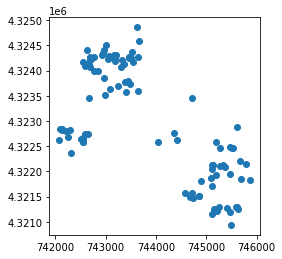

In [64]:
bsu_gpr_sample.plot()

In [61]:
query = session.query(PointData.date)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

# convert to pandas dataframe  
df = query_to_pandas(query, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
dates = sorted(df['date'].unique())
    
print(dates)

[datetime.date(2020, 1, 28), datetime.date(2020, 1, 29), datetime.date(2020, 2, 4), datetime.date(2020, 2, 6), datetime.date(2020, 2, 7), datetime.date(2020, 2, 8), datetime.date(2020, 2, 9)]


Those dates line up with

### ASO data

### Which columns does the ImageData table have?

In [47]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(ImageData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

These are the available columns in the table:
 
* date
* date_accessed
* description
* doi
* instrument
* metadata
* observers
* raster
* registry
* site_name
* time_created
* time_updated
* type
* units



In [3]:
# Locate all that are distinct
airborne_sensors_list = session.query(ImageData.observers).distinct().all()

print('list of airborne sensors by "observer" name: \n', airborne_sensors_list)

list of airborne sensors by "observer" name: 
 [('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


In [6]:
# Query the session using .observers() to generate a list
# Locate all that are distinct
airborne_dataset_types = session.query(ImageData.type).distinct().all()

print('list of airborne sensors by "observer" name')
print(airborne_dataset_types)

list of airborne sensors by "observer" name
[('swe',), ('DEM',), ('insar amplitude',), ('insar correlation',), ('depth',), ('insar interferogram real',), ('insar interferogram imaginary',)]


In [53]:
query = session.query(ImageData.units)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

[('meters',)]


### We want to see the 'swe' 'DEM' and 'depth' data around some area of interest

In [ ]:
query = session.query(func.